In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mesh_import import mesh
import mesh.affix as affix
from mesh.affix import CkipAffixoids
from mesh.affix import AffixoidCtmDataset, AffixoidCtmProcessor
from mesh.affix import AffixoidAnalyzer
from mesh.affix import ctm_analysis

E:\LangOn\OntoDeepLex\src\mesh\cns.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [8]:
ctm = ctm_analysis.get_ctm_models()

In [82]:
ctm.get_beta().shape

torch.Size([100, 18566])

In [ ]:
import numpy as np
from collections import defaultdict

In [ ]:
beta = ctm.model.model.beta.detach().cpu().numpy()

In [ ]:
ctm.model.best_components.shape

In [ ]:
beta.shape

In [ ]:
k=10
topics = defaultdict(list)
for i in range(100):
    idxs = np.argsort(beta[i])[-k:]
    component_words = [ctm.vocab.decode(int(idx))
                       for idx in idxs]
    topics[i] = component_words

In [ ]:
topics[2]

In [ ]:
beta = ctm.get_beta()

In [ ]:
beta.shape

In [12]:
import torch.nn.functional as F
import torch
topic_distr = F.softmax(beta, dim=0)

In [13]:
topic_entropy = (-torch.log(topic_distr) * topic_distr).sum(0)
topic_entropy = topic_entropy.detach().cpu().numpy()

c:\python38\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\python38\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([3.091e+03, 1.536e+03, 2.537e+03, 7.790e+03, 2.398e+03, 2.460e+02,
        6.600e+01, 3.200e+01, 7.000e+00, 8.570e+02]),
 array([2.4568794e-33, 3.0382282e-01, 6.0764563e-01, 9.1146839e-01,
        1.2152913e+00, 1.5191140e+00, 1.8229368e+00, 2.1267595e+00,
        2.4305825e+00, 2.7344053e+00, 3.0382280e+00], dtype=float32),
 <a list of 10 Patch objects>)

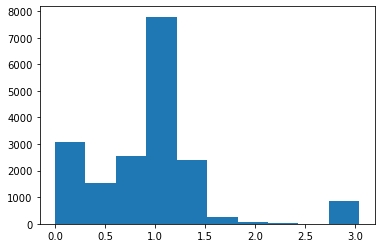

In [16]:
plt.hist(topic_entropy)

## Affixoids

In [13]:
affix_dir = mesh.get_data_dir() / "affix"
affixoids = CkipAffixoids(affix_dir)

In [18]:
ctm.get_affixoid_entropy(affixoids[0])

0.0051618167

In [20]:
from mesh.affix import AffixoidAnalyzer

## Affixoid Analyzer

In [3]:
analyzer = AffixoidAnalyzer()

In [4]:
affix_frame = analyzer.analyze()

In [5]:
affix_frame

,affixoid,affix_type,form,nword,isstart,isend,ex_wfreq,prod_morph,pos_entropy,ctm_entropy
0,一_.1,prefix,一,12,12,0,6.584791,0.814384,2.685945,0.005162
1,乙_.2,prefix,乙,2,2,0,3.401197,-1.559958,1.098612,1.101363
2,七_.3,prefix,七,5,5,0,3.871201,0.191677,1.609438,0.735473
3,九_.4,prefix,九,3,3,0,3.332205,-0.456758,1.098612,1.101872
4,二_.5,prefix,二,15,15,0,6.037871,1.135461,2.426015,0.054771
...,...,...,...,...,...,...,...,...,...,...
4051,_破.441,end-root,破,29,0,29,4.510860,2.934804,1.725214,0.007991
4052,_空.442,end-root,空,17,0,17,3.970292,2.404045,2.302585,1.043647
4053,_白.443,end-root,白,2,0,2,2.484907,-0.780159,0.693147,1.344540
4054,_黃.445,end-root,黃,6,0,6,3.496508,1.004214,1.560710,1.361868


In [81]:
affix_frame.affix_type.value_counts()

suffix        1619
prefix        1215
start-root     921
end-root       301
Name: affix_type, dtype: int64

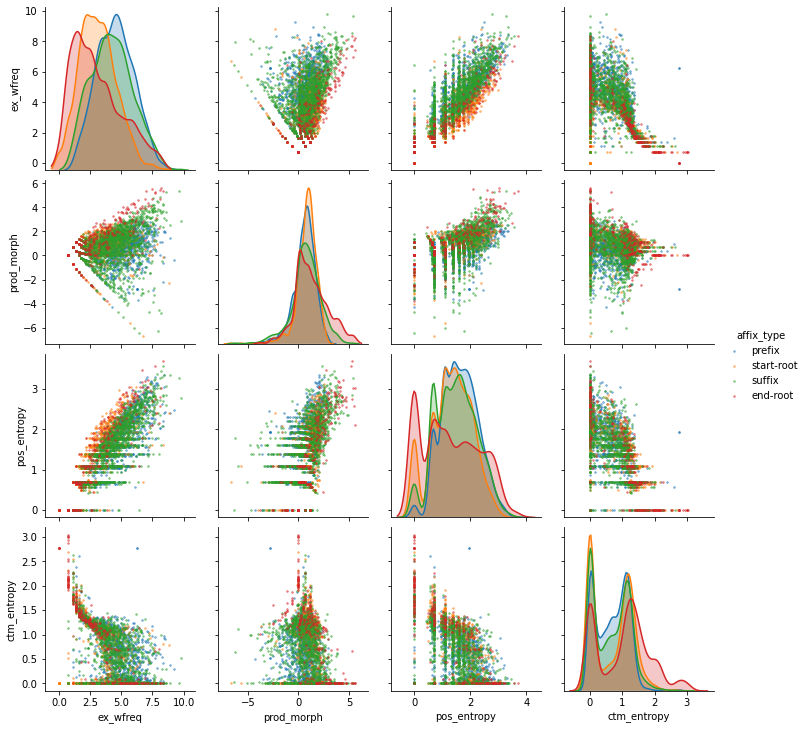

In [53]:
import seaborn as sns
sns.pairplot(affix_frame.loc[:,["affix_type", "ex_wfreq", "prod_morph", "pos_entropy", "ctm_entropy"]], hue="affix_type", 
             plot_kws=dict(edgecolor=None, s=3, alpha=0.5), 
             diag_kws=dict(bw=0.2))

In [8]:
ctm = analyzer.ctm

In [14]:
beta = ctm.get_beta().transpose(1, 0).detach().cpu().numpy()

In [20]:
affix_beta = beta[[ctm.vocab.encode(x.affix_form()) for x in analyzer.affixoids],:]

In [25]:
affix_beta.shape

(4056, 100)

In [58]:
from scipy.spatial.distance import pdist, squareform
import scipy.cluster.hierarchy as hc

dist_vec = pdist(affix_beta, metric="cityblock")
affix_beta_dist = squareform(dist_vec)
linkage = hc.linkage(dist_vec, method='average')

In [86]:
aff_type_cmap = sns.color_palette("muted")
aff_types_2 = {'prefix': 0, 'suffix': 0, 'start-root': 1, 'end-root': 1}
aff_colors_2 = [aff_type_cmap[aff_types_2[x.affixoid_type]] for x in analyzer.affixoids]
aff_types_4 = {'prefix': 0, 'suffix': 1, 'start-root': 2, 'end-root': 3}
aff_colors_4 = [aff_type_cmap[aff_types_4[x.affixoid_type]] for x in analyzer.affixoids]

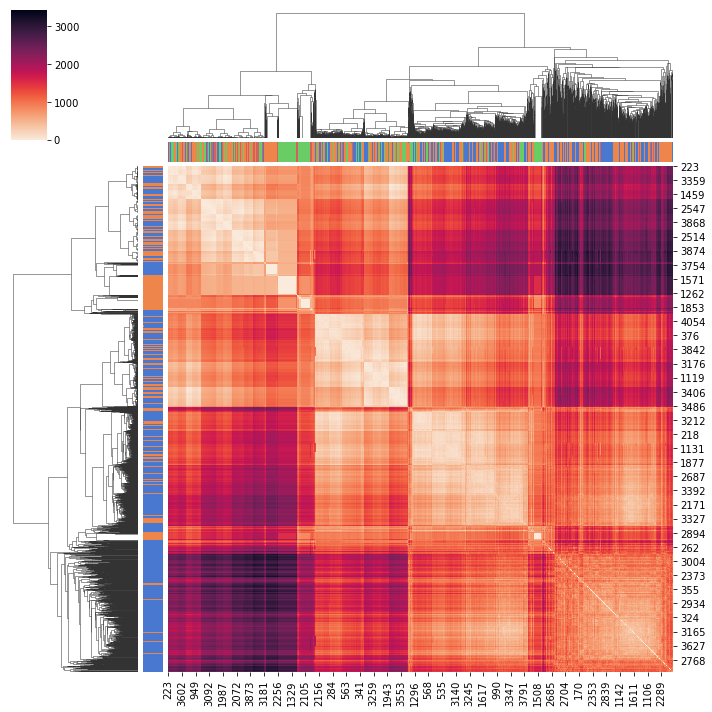

In [87]:
sns.clustermap(affix_beta_dist, row_linkage=linkage, col_linkage=linkage, 
               row_colors=aff_colors_2, 
               col_colors=aff_colors_4,
               cmap="rocket_r")

In [78]:
N_CLUST = 3
cluster_idx = hc.cut_tree(linkage, N_CLUST).squeeze()

In [79]:
from collections import Counter
import random
for c in range(N_CLUST):
    aff_list = [x for i, x in enumerate(analyzer.affixoids) if cluster_idx[i]==c]
    aff_types = [x.affixoid_type for x in aff_list]
    print(Counter(aff_types))
    random.shuffle(aff_list)
    for x in aff_list[:10]:
        print(x, end='')
        print([y[1] for y in x.example_words[:10]])
    print()


Counter({'suffix': 478, 'prefix': 433, 'start-root': 32, 'end-root': 22})
<Affix(Prefix): 內>['內力', '內孫子', '內文', '內皮', '內在', '內外角', '內生性', '內電阻', '內頁', '內家']
<Affix(Suffix): 段>['中段', '句段', '河段', '波段', '時段', '區段', '階段', '路段', '樂段', '線段']
<Affix(Prefix): 俗>['俗人', '俗民', '俗物', '俗花', '俗情', '俗壽', '俗漢', '俗稱', '俗諺']
<Root(Start): 必>['必修', '必勝', '必須', '必然']
<Affix(Prefix): 奇>['奇人', '奇技', '奇岩', '奇招', '奇俗', '奇珍', '奇峰', '奇景', '奇想', '奇葩']
<Root(End): 對>['找對', '走對', '押對', '玩對', '背對', '問對', '猜對', '設計對', '說對', '選對']
<Affix(Suffix): 纖>['人纖', '光纖', '合纖', '法纖', '長纖', '玻纖', '紡纖', '碳纖', '穠纖']
<Affix(Suffix): 式>['句式', '曲式', '典式', '法式', '型式', '陣式', '圖式', '態式', '分列式', '手動式']
<Affix(Prefix): 真>['真主', '真兇', '真我', '真知', '真空', '真品', '真值', '真假', '真象', '真傳']
<Affix(Prefix): 玩>['玩伴', '玩法', '玩家', '玩意', '玩興', '玩藝']

Counter({'suffix': 748, 'prefix': 646, 'start-root': 425, 'end-root': 86})
<Affix(Suffix): 椒>['青椒', '胡椒', '紅山椒']
<Affix(Prefix): 間>['間板', '間格', '間距', '間關節', '間數']
<Affix(Prefix): 棚>['棚屋', '棚架', '棚面', '棚廠']


In [67]:
aff_list[0][:10]

TypeError: 'Affix' object is not subscriptable